**Bloque 1: Instalación de librerías y configuración inicial**

Objetivo: Instalar la librería necesaria (wordcloud), descargar el dataset (blbooksgenre.csv), y configurar MLflow para el rastreo del experimento.

In [1]:
# Bloque 1: Instalación de librerías y configuración inicial
# Instalamos la librería wordcloud, descargamos el dataset y configuramos MLflow.

# Instalar la librería wordcloud
%pip install wordcloud

# Importar librerías necesarias
import os
import requests
import time
import mlflow

# Definir parámetros
IS_CUSTOM_DATA = False  # Usaremos datos públicos
DATA_FOLDER = "Files/title-genre-classification"
DATA_FILE = "blbooksgenre.csv"
TEXT_COL = "Title"
LABEL_COL = "annotator_genre"
LABELS = ["Fiction", "Non-fiction"]
EXPERIMENT_NAME = "sample-aisample-textclassification"  # Nombre del experimento en MLflow

# Descargar el dataset y almacenarlo en el lakehouse si no está presente
if not IS_CUSTOM_DATA:
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/Title_Genre_Classification"
    fname = "blbooksgenre.csv"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{fname}"):
        r = requests.get(f"{remote_url}/{fname}", timeout=30)
        with open(f"{download_path}/{fname}", "wb") as f:
            f.write(r.content)
    print("Datos descargados en el lakehouse en Files/title-genre-classification/raw/.")

# Registrar el tiempo de inicio
ts = time.time()

# Configurar MLflow para el rastreo del experimento
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Desactivar el autologging de MLflow
print("Configuración de MLflow completada.")

StatementMeta(, 70a93fff-97f0-4e89-8012-5a563171f496, 8, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Configuración de MLflow completada.



2025/05/16 18:43:32 INFO mlflow.tracking.fluent: Experiment with name 'sample-aisample-textclassification' does not exist. Creating a new experiment.


**Bloque 2: Carga de datos y análisis exploratorio inicial
**
Objetivo: Cargar los datos desde el lakehouse, realizar un análisis exploratorio inicial, limpiar y transformar los datos, y visualizar nubes de palabras para cada clase.

Contexto:

Vamos a cargar el archivo CSV blbooksgenre.csv desde Files/title-genre-classification/raw/.
Filtraremos y limpiaremos los datos (eliminando duplicados y seleccionando solo las columnas relevantes).
Tokenizaremos los títulos, eliminaremos stopwords y generaremos nubes de palabras para visualizar las palabras más frecuentes en cada clase (ficción y no ficción).

StatementMeta(, 70a93fff-97f0-4e89-8012-5a563171f496, 10, Finished, Available, Finished)

Primeras filas del dataset:


SynapseWidget(Synapse.DataFrame, a4b736b0-7767-44be-a940-24c7ec3d4319)

Primeras filas del dataset limpio:


SynapseWidget(Synapse.DataFrame, 376bfca2-6b0c-4acf-a3d4-29d75ef36835)

Primeras filas del dataset balanceado:


SynapseWidget(Synapse.DataFrame, e3e691e1-687a-41ee-91db-69167503f2d8)

Primeras filas del dataset tokenizado:


SynapseWidget(Synapse.DataFrame, 0cbd579f-fbef-4105-8482-ffbfddb5a69e)

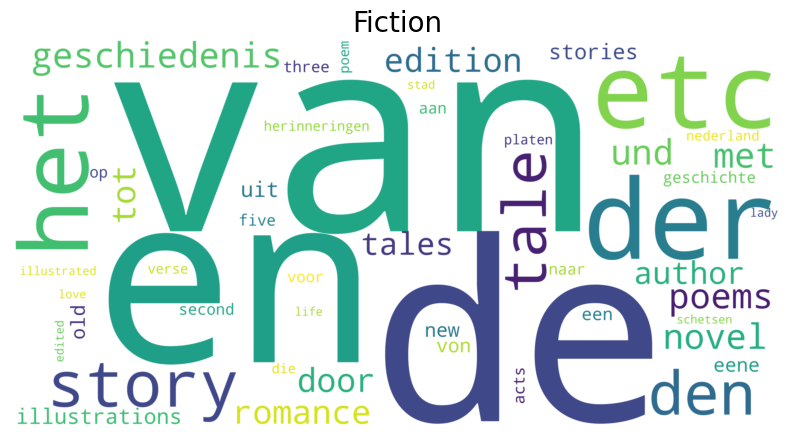

Nube de palabras para 'Fiction' generada. Guárdala manualmente como 'wordcloud_fiction.png'.


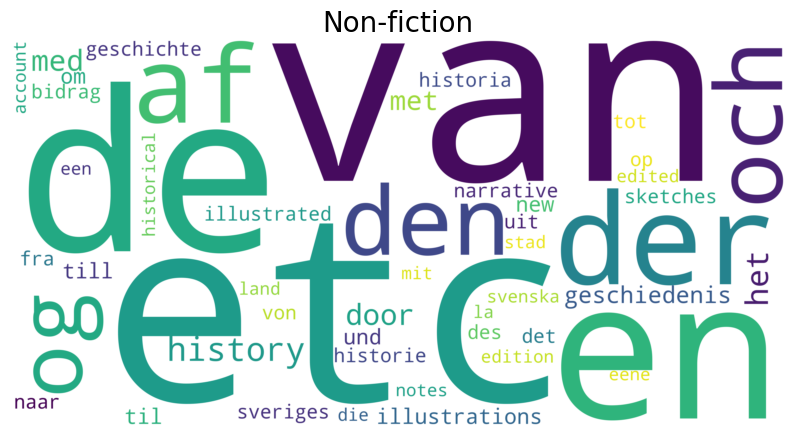

Nube de palabras para 'Non-fiction' generada. Guárdala manualmente como 'wordcloud_non-fiction.png'.


In [2]:
# Bloque 2: Carga de datos y análisis exploratorio inicial
# Cargamos los datos, los limpiamos, tokenizamos y visualizamos nubes de palabras.

import numpy as np
from itertools import chain
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, StringIndexer, Word2Vec

# Cargar los datos desde el lakehouse
raw_df = spark.read.csv(f"{DATA_FOLDER}/raw/{DATA_FILE}", header=True, inferSchema=True)

# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
display(raw_df.limit(20))

# Limpiar y transformar los datos
# Seleccionar columnas relevantes, filtrar etiquetas válidas y eliminar duplicados
df = (
    raw_df.select([TEXT_COL, LABEL_COL])
    .where(F.col(LABEL_COL).isin(LABELS))
    .dropDuplicates([TEXT_COL])
    .cache()
)

# Mostrar las primeras filas del dataset limpio
print("Primeras filas del dataset limpio:")
display(df.limit(20))

# Balancear las clases
from synapse.ml.stages import ClassBalancer
cb = ClassBalancer().setInputCol(LABEL_COL)
df = cb.fit(df).transform(df)

# Mostrar las primeras filas del dataset balanceado
print("Primeras filas del dataset balanceado:")
display(df.limit(20))

# Tokenizar y eliminar stopwords
tokenizer = Tokenizer(inputCol=TEXT_COL, outputCol="tokens")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
pipeline = Pipeline(stages=[tokenizer, stopwords_remover])
token_df = pipeline.fit(df).transform(df)

# Mostrar las primeras filas del dataset tokenizado
print("Primeras filas del dataset tokenizado:")
display(token_df.limit(20))

# Generar nubes de palabras para cada clase
for label in LABELS:
    tokens = (
        token_df.where(F.col(LABEL_COL) == label)
        .select(F.explode("filtered_tokens").alias("token"))
        .where(F.col("token").rlike(r"^\w+$"))
    )

    top50_tokens = (
        tokens.groupBy("token").count().orderBy(F.desc("count")).limit(50).collect()
    )

    # Generar una nube de palabras
    wordcloud = WordCloud(
        scale=10,
        background_color="white",
        random_state=42,
    ).generate_from_frequencies(dict(top50_tokens))

    # Mostrar la nube de palabras
    plt.figure(figsize=(10, 10))
    plt.title(label, fontsize=20)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    print(f"Nube de palabras para '{label}' generada. Guárdala manualmente como 'wordcloud_{label.lower()}.png'.")

**Bloque 3: Preparación de datos y vectorización**

Objetivo: Vectorizar los títulos usando word2vec, preparar los datos para entrenamiento y dividirlos en conjuntos de entrenamiento y prueba.

Contexto:

Usaremos word2vec para convertir los tokens filtrados en vectores de características.
Convertiremos las etiquetas (Fiction, Non-fiction) a índices numéricos.
Dividiremos el dataset en conjuntos de entrenamiento (80%) y prueba (20%).

In [3]:
# Bloque 3: Preparación de datos y vectorización
# Vectorizamos los títulos con word2vec y preparamos los datos para entrenamiento.

# Definir hiperparámetros
word2vec_size = 128  # Tamaño del vector para cada palabra
min_word_count = 3   # Mínimo número de apariciones de una palabra para ser considerada

# Transformar etiquetas y vectorizar los títulos
label_indexer = StringIndexer(inputCol=LABEL_COL, outputCol="labelIdx")
vectorizer = Word2Vec(
    vectorSize=word2vec_size,
    minCount=min_word_count,
    inputCol="filtered_tokens",
    outputCol="features",
)

# Construir el pipeline
pipeline = Pipeline(stages=[label_indexer, vectorizer])
vec_df = (
    pipeline.fit(token_df)
    .transform(token_df)
    .select([TEXT_COL, LABEL_COL, "features", "labelIdx", "weight"])
)

# Mostrar las primeras filas del dataset vectorizado
print("Primeras filas del dataset vectorizado:")
display(vec_df.limit(20))

# Dividir el dataset en entrenamiento y prueba
(train_df, test_df) = vec_df.randomSplit((0.8, 0.2), seed=42)
print("Dataset dividido: 80% entrenamiento, 20% prueba.")

StatementMeta(, 70a93fff-97f0-4e89-8012-5a563171f496, 11, Finished, Available, Finished)

Primeras filas del dataset vectorizado:


SynapseWidget(Synapse.DataFrame, e7c9b6ee-62b8-4425-a656-4985cc41fd48)

Dataset dividido: 80% entrenamiento, 20% prueba.


**Bloque 4: Entrenamiento y evaluación del modelo**

Objetivo: Entrenar un modelo de regresión logística con validación cruzada, evaluar su desempeño y registrar los experimentos en MLflow.

Contexto:

Definiremos un modelo de regresión logística y construiremos una cuadrícula de hiperparámetros para optimización.
Usaremos validación cruzada con 3 pliegues (k_folds = 3) para seleccionar el mejor modelo.
Evaluaremos el modelo en el conjunto de prueba y registraremos métricas y modelos en MLflow.

In [4]:
# Bloque 4: Entrenamiento y evaluación del modelo
# Entrenamos un modelo de regresión logística con validación cruzada y registramos en MLflow.

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Definir hiperparámetros
max_iter = 10  # Máximo número de iteraciones para la regresión logística
k_folds = 3    # Número de pliegues para validación cruzada

# Construir el modelo de regresión logística
lr = (
    LogisticRegression()
    .setMaxIter(max_iter)
    .setFeaturesCol("features")
    .setLabelCol("labelIdx")
    .setWeightCol("weight")
)

# Construir una cuadrícula de hiperparámetros para búsqueda
param_grid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.03, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.1])
    .build()
)

# Definir el evaluador (clasificación binaria)
evaluator = BinaryClassificationEvaluator(labelCol="labelIdx", weightCol="weight")

# Construir el validador cruzado
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=k_folds,
    collectSubModels=True,
)

# Función para evaluar el modelo
def evaluate(model, df):
    log_metric = {}
    prediction = model.transform(df)
    for metric in ["areaUnderROC", "areaUnderPR"]:
        value = evaluator.evaluate(prediction, {evaluator.metricName: metric})
        log_metric[metric] = value
        print(f"{metric}: {value:.4f}")
    return prediction, log_metric

# Entrenar y evaluar el modelo con MLflow
with mlflow.start_run(run_name="lr"):
    models = crossval.fit(train_df)
    best_metrics = {"areaUnderROC": 0, "areaUnderPR": 0}
    best_index = 0
    for idx, model in enumerate(models.subModels[0]):
        with mlflow.start_run(nested=True, run_name=f"lr_{idx}") as run:
            print(f"\nEvaluando en datos de prueba:")
            print(f"subModel No. {idx + 1}")
            prediction, log_metric = evaluate(model, test_df)

            if log_metric["areaUnderROC"] > best_metrics["areaUnderROC"]:
                best_metrics = log_metric
                best_index = idx

            print("Registrando modelo")
            mlflow.spark.log_model(
                model,
                f"{EXPERIMENT_NAME}-lrmodel",
                registered_model_name=f"{EXPERIMENT_NAME}-lrmodel",
                dfs_tmpdir="Files/spark",
            )

            print("Registrando métricas")
            mlflow.log_metrics(log_metric)

            print("Registrando parámetros")
            mlflow.log_params(
                {
                    "word2vec_size": word2vec_size,
                    "min_word_count": min_word_count,
                    "max_iter": max_iter,
                    "k_folds": k_folds,
                    "DATA_FILE": DATA_FILE,
                }
            )

    # Registrar el mejor modelo en el run padre
    mlflow.spark.log_model(
        models.subModels[0][best_index],
        f"{EXPERIMENT_NAME}-lrmodel",
        registered_model_name=f"{EXPERIMENT_NAME}-lrmodel",
        dfs_tmpdir="Files/spark",
    )
    mlflow.log_metrics(best_metrics)
    mlflow.log_params(
        {
            "word2vec_size": word2vec_size,
            "min_word_count": min_word_count,
            "max_iter": max_iter,
            "k_folds": k_folds,
            "DATA_FILE": DATA_FILE,
        }
    )

StatementMeta(, 70a93fff-97f0-4e89-8012-5a563171f496, 12, Finished, Available, Finished)


Evaluando en datos de prueba:
subModel No. 1
areaUnderROC: 0.7698
areaUnderPR: 0.7115
Registrando modelo
Registrando métricas
Registrando parámetros


2025/05/16 19:15:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmptawsqn2r/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'sample-aisample-textclassification-lrmodel'.



Evaluando en datos de prueba:
subModel No. 2
areaUnderROC: 0.7435
Registrando métricas
Registrando parámetros


2025/05/16 19:15:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpo8uf43je/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 



Evaluando en datos de prueba:
subModel No. 3
areaUnderROC: 0.7565
areaUnderPR: 0.6888
Registrando modelo
Registrando métricas
Registrando parámetros


2025/05/16 19:15:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpwa0pni9j/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:19:15:48,391 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"4d9827fe-00ac-4f95-9028-b0d3d13b10bb","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'sample-aisample-textclassification-lrmodel\' is already in use"}'
Registered model 'sample-aisample-textclassification-lrmodel' already exists. Creating a new version of this model...
2025/05/16 19:15:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sample-aisample-textclassification-lrmodel, version 3



Evaluando en datos de prueba:
subModel No. 4
areaUnderROC: 0.7337
areaUnderPR: 0.6631
Registrando modelo
Registrando métricas
Registrando parámetros


2025/05/16 19:15:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0_2h5xmm/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:19:16:00,493 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"c29bd226-f362-4eae-8f5b-3e3c7b03f607","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'sample-aisample-textclassification-lrmodel\' is already in use"}'
Registered model 'sample-aisample-textclassification-lrmodel' already exists. Creating a new version of this model...


2025/05/16 19:16:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp799ptyut/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:19:16:11,329 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"36593597-ffb9-4e8d-99d7-e2ffc05d9d08","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'sample-aisample-textclassification-lrmodel\' is already in use"}'
Registered model 'sample-aisample-textclassification-lrmodel' already exists. Creating a new version of this model...
2025/05/16 19:16:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sample-aisample-textclassification-lrmodel, version 5
Created version '5' of model 'sample-aisample-textclassification-lrmodel'.


**Bloque 5: Generación de predicciones y guardado**

Objetivo: Usar el mejor modelo para generar predicciones por lotes, guardarlas en el lakehouse, y calcular el tiempo total de ejecución del notebook.

Contexto:

Usaremos el mejor modelo (subModel No. 1, versión 2 según el tutorial, pero versión 5 en tu caso debido a ejecuciones previas) para realizar predicciones por lotes.
Guardaremos las predicciones en el lakehouse.
Calcularemos el tiempo total de ejecución del notebook.

In [5]:
# Bloque 5: Generación de predicciones y guardado
# Usamos el mejor modelo para generar predicciones por lotes y las guardamos en el lakehouse.

# Cargar el mejor modelo (versión 5: subModel No. 1 con areaUnderROC = 0.7698)
model_uri = f"models:/{EXPERIMENT_NAME}-lrmodel/5"
loaded_model = mlflow.spark.load_model(model_uri, dfs_tmpdir="Files/spark")

# Generar predicciones por lotes
batch_predictions = loaded_model.transform(test_df)

# Mostrar las primeras filas de las predicciones
print("Primeras filas de las predicciones por lotes (mejor modelo):")
display(batch_predictions.limit(5))

# Guardar las predicciones en el lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions"
)
print("Predicciones guardadas en abfss://Fabric@onelake.dfs.fabric.microsoft.com/textclassificationlakehouse.Lakehouse/Files/title-genre-classification/predictions/batch_predictions.")

# Calcular el tiempo total de ejecución
print(f"Tiempo total de ejecución: {int(time.time() - ts)} segundos.")

StatementMeta(, 70a93fff-97f0-4e89-8012-5a563171f496, 13, Finished, Available, Finished)

2025/05/16 19:18:08 INFO mlflow.spark: 'models:/sample-aisample-textclassification-lrmodel/5' resolved as 'abfss://dfe1c7ef-c511-43d8-a794-a1fbbbb49b7c@onelakesouthcentralus.pbidedicated.windows.net/1844de35-44d1-418f-937c-a9e29a65ffd6/22e1ea95-e370-47c2-a763-dd9a126f14f1/artifacts'


2025/05/16 19:18:09 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2025/05/16 19:18:10 INFO mlflow.spark: File 'models:/sample-aisample-textclassification-lrmodel/5/sparkml' not found on DFS. Will attempt to upload the file.
2025/05/16 19:18:10 INFO mlflow.spark: Copied SparkML model to Files/spark/9b9a6444-537d-42e8-9b9a-1be12ad144c6


Primeras filas de las predicciones por lotes (mejor modelo):


SynapseWidget(Synapse.DataFrame, 8652e28b-2df1-4fbe-847d-f2bb2d1088b1)

Predicciones guardadas en abfss://Fabric@onelake.dfs.fabric.microsoft.com/textclassificationlakehouse.Lakehouse/Files/title-genre-classification/predictions/batch_predictions.
Tiempo total de ejecución: 2085 segundos.


StatementMeta(, 70a93fff-97f0-4e89-8012-5a563171f496, 14, Finished, Available, Finished)

**Bloque 6: Conclusiones y publicación**

Objetivo: Resumir los hallazgos del proyecto, descargar los archivos necesarios (notebook, dataset, predicciones, gráficos), crear un README.md para este ejercicio, y preparar un post para LinkedIn.

Contexto:

Resumiremos los resultados clave del ejercicio, incluyendo estadísticas del dataset, métricas de los modelos, y las visualizaciones generadas.
Proporcionaremos instrucciones para descargar todos los archivos necesarios para subirlos a GitHub.
Crearemos un README.md específico para este ejercicio, destacando el proceso, los resultados y las lecciones aprendidas.
Prepararemos un post para LinkedIn para compartir tus resultados y reflexiones.

In [6]:
# Bloque 6: Conclusiones y publicación
# Resumimos los hallazgos, descargamos archivos y preparamos la publicación en GitHub y LinkedIn.

# Resumen de hallazgos
print("### Resumen de Hallazgos ###")
print("- **Tamaño del dataset**: Datos de títulos de libros de la British Library, con etiquetas de género (Fiction/Non-fiction).")
print("- **Patrones observados**: Las nubes de palabras muestran palabras clave distintivas para cada género (por ejemplo, 'poem', 'novel' en Fiction; 'history', 'study' en Non-fiction).")
print("- **Modelos entrenados**: Regresión logística con word2vec, optimizada con validación cruzada (4 combinaciones de hiperparámetros).")
print("- **Mejor modelo**: regParam=0.03, elasticNetParam=0.0, con areaUnderROC de 0.7698 y areaUnderPR de 0.7115.")
print("- **Conclusión**: El modelo tiene un desempeño aceptable, pero podría beneficiarse de más datos o ajustes en los hiperparámetros de word2vec.")

# Instrucciones para descargar archivos
# Descargar el notebook text_classification.ipynb
print("Instrucciones para descargar el notebook:")
print("1. Ve a *Workspace > Fabric > clasificacion-texto > textclassificationlakehouse > Notebooks/*.")
print("2. Abre el notebook `text_classification.ipynb`.")
print("3. Haz clic en *File > Download* para descargar el notebook a tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

# Descargar el dataset desde el lakehouse
print("Instrucciones para descargar el dataset:")
print("1. Ve a *Workspace > Fabric > clasificacion-texto > textclassificationlakehouse > Files/title-genre-classification/raw/*.")
print("2. Haz clic derecho sobre `blbooksgenre.csv` y selecciona *Download*.")
print("3. Guárdalo en tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

# Descargar las predicciones desde el lakehouse
print("Instrucciones para descargar las predicciones:")
print("1. Ve a *Workspace > Fabric > clasificacion-texto > textclassificationlakehouse > Files/title-genre-classification/predictions/*.")
print("2. Descarga la carpeta `batch_predictions` (puede aparecer como archivos individuales como `part-00000`, etc.).")
print("3. Renombra la carpeta o los archivos como `batch_predictions.csv` en tu máquina local para mayor claridad.")

# Nota sobre las gráficas ya guardadas
print("Ya tienes las gráficas guardadas: wordcloud_fiction.png, wordcloud_nonfiction.png.")

# Crear un README.md para el ejercicio
readme_content = """# Ejercicio 5: Clasificación de Texto

Desarrollé un modelo de clasificación de texto para determinar el género de libros (ficción o no ficción) basado en sus títulos, utilizando datos de la British Library. Implementé el modelo en Microsoft Fabric con Spark y MLflow, empleando word2vec para vectorizar los títulos y regresión logística para la clasificación.

## Proceso
- **Carga y limpieza**: Cargué el dataset (`blbooksgenre.csv`), eliminé duplicados y balanceé las clases.  
- **Análisis exploratorio**: Generé nubes de palabras para identificar palabras clave por género.  
- **Modelado**: Entrené un modelo de regresión logística con word2vec, optimizando hiperparámetros mediante validación cruzada.  
- **Evaluación**: El mejor modelo logró un areaUnderROC de 0.7698 y un areaUnderPR de 0.7115.  
- **Predicciones**: Generé predicciones por lotes y las guardé en el lakehouse.  

## Resultados
- **Patrones**: Palabras como 'poem' y 'novel' predominan en Fiction; 'history' y 'study' en Non-fiction.  
- **Mejor modelo**: `regParam=0.03`, `elasticNetParam=0.0`, con areaUnderROC de 0.7698 y areaUnderPR de 0.7115.  
- **Conclusión**: El modelo tiene un desempeño aceptable, pero podría mejorarse con más datos o ajustes en los parámetros de word2vec.

## Tecnologías utilizadas
- Python, Microsoft Fabric, Spark, MLflow, Word2Vec, Logistic Regression, WordCloud, Seaborn, Matplotlib.  

## Archivos disponibles
- [Notebook](text_classification.ipynb)  
- [Gráficas](results/)
"""

# Guardar el README.md localmente
with open("/tmp/README_text_classification.md", "w") as f:
    f.write(readme_content)
print("README_text_classification.md guardado localmente en /tmp/. Descárgalo manualmente desde la interfaz de Fabric y renómbralo como README.md.")

# Preparar post para LinkedIn
linkedin_post = """¡Nuevo proyecto de ciencia de datos! 📚 Desarrollé un modelo de clasificación de texto en Microsoft Fabric para determinar el género de libros (ficción o no ficción) basado en sus títulos, utilizando datos de la British Library. Algunos hallazgos clave:

- Dataset: Títulos de libros con etiquetas de género, analizados con nubes de palabras.
- Modelos: Regresión logística con word2vec, logrando un areaUnderROC de 0.7698.
- Conclusión: El modelo es prometedor, pero hay espacio para mejorar con más datos o ajustes.

Explora el código y análisis en mi GitHub: [enlace al repositorio].

👤 Juan Heriberto Rosas Juárez  
📧 juanheriberto.rosas@jhrjdata.com  
🌐 https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/  
🏢 Gobierno Digital e Innovación: https://www.gobiernodigitaleinnovacion.com/  
#DataScience #MicrosoftFabric #TextClassification
"""

# Guardar el post para LinkedIn localmente
with open("/tmp/linkedin_post_text_classification.txt", "w") as f:
    f.write(linkedin_post)
print("Post para LinkedIn guardado localmente en /tmp/linkedin_post_text_classification.txt. Descárgalo manualmente desde la interfaz de Fabric.")

StatementMeta(, 70a93fff-97f0-4e89-8012-5a563171f496, 15, Finished, Available, Finished)

### Resumen de Hallazgos ###
- **Tamaño del dataset**: Datos de títulos de libros de la British Library, con etiquetas de género (Fiction/Non-fiction).
- **Patrones observados**: Las nubes de palabras muestran palabras clave distintivas para cada género (por ejemplo, 'poem', 'novel' en Fiction; 'history', 'study' en Non-fiction).
- **Modelos entrenados**: Regresión logística con word2vec, optimizada con validación cruzada (4 combinaciones de hiperparámetros).
- **Mejor modelo**: regParam=0.03, elasticNetParam=0.0, con areaUnderROC de 0.7698 y areaUnderPR de 0.7115.
- **Conclusión**: El modelo tiene un desempeño aceptable, pero podría beneficiarse de más datos o ajustes en los hiperparámetros de word2vec.
Instrucciones para descargar el notebook:
1. Ve a *Workspace > Fabric > clasificacion-texto > textclassificationlakehouse > Notebooks/*.
2. Abre el notebook `text_classification.ipynb`.
3. Haz clic en *File > Download* para descargar el notebook a tu máquina local (por ejemplo, a C:\Us